In [9]:
import sys
import getopt
import pandas as pd
from fancyimpute import KNN
from multiprocessing import Pool
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

# Set variables and defaults
input_profiles = '../data/profiles.csv'
input_layers = '../data/layers.csv'
input_file = ''
outputfile = '../data/classified_data.csv'
threshold = 0.01
country_filter = 'MX'
knn = 0

profiles = pd.read_csv(input_profiles)
layers = pd.read_csv(input_layers)

print('Merging and cleaning data.')

# Selecting only those classified using WRB
classified_profiles = profiles[~profiles['cwrb_reference_soil_group'].isnull(
)]

# Merging of the files
classified_data = layers.merge(classified_profiles, how="inner", left_on=[
    'profile_id'], right_on=['profile_id'])

# Filter by country
if country_filter != '':
    classified_data = classified_data.loc[classified_data['country_id']
                                          == country_filter]

# Replace Albeluvisols with Retisols as was made in the latest version of WRB
classified_data.loc[classified_data['cwrb_reference_soil_group']
                    == 'Albeluvisols', 'cwrb_reference_soil_group'] = 'Retisols'

# Drop columns that are not numeric / not necessary (licenses)
classified_data = classified_data.drop(columns=['dataset_id', 'country_id', 'cfao_version', 'cfao_major_group',
                                                'cwrb_version', 'cwrb_reference_soil_group', 'cstx_version',
                                                'cstx_order_name', 'translated', 'profile_layer_id'])
classified_data = classified_data.drop(columns=list(
    classified_data.loc[:, classified_data.columns.str.contains('license')]))

# Remove the columns that have only missing values
classified_data = classified_data.dropna(axis=1, how='all')

# Remove all columns with more null values than allowed by the threshold
c = classified_data.count().apply(lambda x: x/classified_data.shape[0])
classified_data = classified_data.drop(
    columns=c[c < threshold].index.tolist())

# Remove rows where lower depth is clearly outlier
classified_data = classified_data[classified_data.lower_depth < 999]

# Add Thickness
classified_data['thickness'] = classified_data.apply(
    lambda row: row['lower_depth'] - row['upper_depth'], axis=1)

print('Cleaned data has {} rows and {} columns'.format(
    classified_data.shape[0], classified_data.shape[1]) + (', filtered by {}'.format(country_filter) if country_filter != '' else ''))



/usr/local/Cellar/ipython/7.5.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (53,54,55,56,57,58,61,62,63,64,65,67,68,69,70,71,72,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Merging and cleaning data.
Cleaned data has 19440 rows and 13 columns, filtered by MX


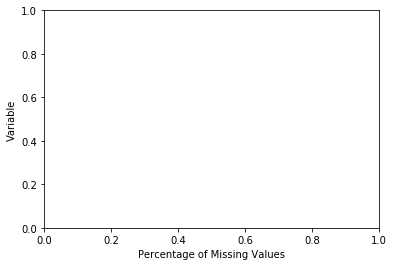

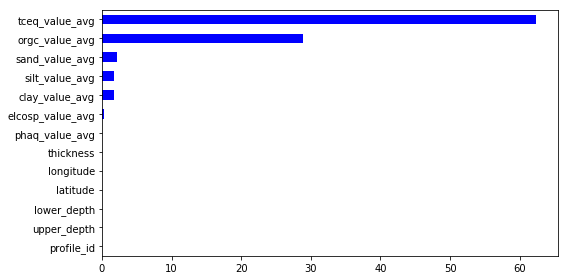

In [30]:
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Variable")
plt.figure(figsize=(8,4))
df.isna().sum().divide(df.shape[0]).multiply(100).sort_values(ascending=True).plot(kind='barh', color="blue")
plt.tight_layout()
plt.savefig("count_nulls.pdf")

In [12]:
plt.show()